# Bilingual Evaluation Understudy(BLEU) Score

In [4]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk.util import ngrams
from collections import Counter
import sacrebleu
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/shankar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## BLEU Score
$$BLEU = BP(\prod_{i=1}^4 precision_i)^{(1/4)}$$
with the Brevity Penalty and Precision defined as...
$$BP = min(1, e^{(1-\frac{ref}{cand})})$$
$$precision_i = \frac{\sum_{snt\in cand}\sum_{i \in snt}min(m_{cand}^i, m_{ref}^i)}{w_t^i}$$

Where,
- $m_{cand}^i$, is the count of i-gram in candidate matching the referece translation
- $m_{ref}^i$, is the count of i-gram in the reference translation
- $w_t^i$ is the total number of i-grams in candidate translation

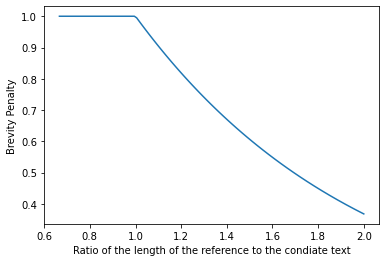

In [5]:
ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x
y = np.exp(y)
y = np.minimum(np.ones(y.shape), y)

# Code for in order to make the plot
fig, ax = plt.subplots(1)
lines = ax.plot(x, y)
ax.set(
    xlabel = "Ratio of the length of the reference to the condiate text",
    ylabel = "Brevity Penalty"
)
plt.show()

- The brevity penalty penalizes generated translations that are too short compared to the closest reference length with an exponential decay
- The brevity penalty compensates for the fact that the BLEU score has no recall term.

### N-Gram Precision

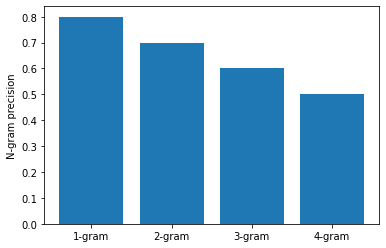

In [7]:
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")
plt.show()

- The n-gram precision counts how many unigrams, bigrams, trigrams and four-grams (i=1,2,3,4) match their n-gram counterpart in the reference translations
- This term acts as a precision metric. 
- Unigrams account for adequacy while longer n-grams account for fluency of the translation
- To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference $m_n^{ref}$
- Precision shows exponential decay with the with the degree of the n-gram

### N-gram BLEU Score

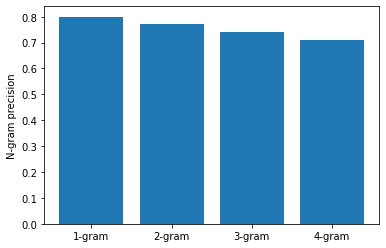

In [8]:
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")
plt.show()

- When the n-gram precisin is multiplied by the BP, then the exponential decay of n-grams is almost fully compensated
- The BLEU score corresponds to a geometric average of this modified n-gram precision

## Calculations of BLEU Score

In [10]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


### Step 1: Computing Brevity Penalty

In [11]:
def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    can_length = len(candidate)
    
    # Brevity Penalty
    if(ref_length > can_length):
        BP = 1
    else:
        penalty = 1 - (ref_length / can_length)
        BP = np.exp(penalty)
        
    return BP

### Step 2: Computing the Precision

In [13]:
def clipped_precision(reference, candidate):
    # BLEU score function given a original and machine translated sentences
    clipped_precision_score = []
    
    for i in range(1, 5):
        # Counts of n-gram = n = 1,...,4 tokens for the candidate
        candidate_n_gram = Counter(ngrams(candidate, i))
        # Counts of n-gram n=1,...4 tokens for the reference
        reference_n_gram = Counter(ngrams(reference, i))
        # Sum of the values of the reference the denominator in the precision formula
        c = sum(reference_n_gram.values())
        
        # For every n_gram token in the reference
        for j in reference_n_gram:
            if(j in candidate_n_gram):
                if(reference_n_gram[j] > candidate_n_gram[j]):
                    # if the count of the reference n-gram is bigger
                    # than the corresponding count in the candidate n-gram
                    reference_n_gram[j] = candidate_n_gram[j]
            else:
                reference_n_gram[j] = 0
        clipped_precision_score.append(sum(reference_n_gram.values()) / c)
        
    weights = [0.25] * 4
    
    s = (w_i * np.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = np.exp(np.sum(s))
    
    return s

### Step 3: Computing the BLEU Score

In [14]:
def bleu_score(reference, candidate):
    BP = brevity_penalty(reference, candidate)
    precision = clipped_precision(reference, candidate)
    return BP * precision

### Step 4: Testing with Reference Sentences

In [15]:
print(
    "Results reference versus candidate 1 our own code BLEU: ",
    round(bleu_score(tokenized_ref, tokenized_cand_1) * 100, 1),
)
print(
    "Results reference versus candidate 2 our own code BLEU: ",
    round(bleu_score(tokenized_ref, tokenized_cand_2) * 100, 1),
)

Results reference versus candidate 1 our own code BLEU:  27.4
Results reference versus candidate 2 our own code BLEU:  35.0


<ipython-input-13-864f85b74cb6>:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s = np.exp(np.sum(s))


### Step 5: Compare Results with SacreBleu

In [16]:
print(
    "Results reference versus candidate 1 sacrebleu library sentence BLEU: ",
    round(sacrebleu.corpus_bleu(reference, candidate_1).score, 1),
)
print(
    "Results reference versus candidate 2 sacrebleu library sentence BLEU: ",
    round(sacrebleu.corpus_bleu(reference, candidate_2).score, 1),
)

Results reference versus candidate 1 sacrebleu library sentence BLEU:  27.4
Results reference versus candidate 2 sacrebleu library sentence BLEU:  35.0


## 2. BLEU computation on a Corpus
- A simple pipeline for evaluating machine translated text is demonstrated
- Google translate is used to generate English to German translations
- Results are evaluated against a known evaluation set

1. A src text in englies. first 1671 words of wmt19 eval set downloaded via SacreBLEU from a subset.
2. A reference translation to German for corresponding 1671 words, provided by SacreBLEU
3. A candidate Machine Translation to German from the same 1671 words, This is generated by feeding the src text to a MT model

In [17]:
import os
DATA_DIR = './data/01'
src_file = os.path.join(DATA_DIR, "wmt19_src.txt")
wmt19news_src = open(src_file, "rU")
wmt19news_src_1 = wmt19news_src.read()
wmt19news_src.close()

ref_file = os.path.join(DATA_DIR, "wmt19_ref.txt")
wmt19news_ref = open(ref_file, "rU")
wmt19news_ref_1 = wmt19news_ref.read()
wmt19news_ref.close()

can_file = os.path.join(DATA_DIR, "wmt19_can.txt")
wmt19news_can = open(can_file, "rU")
wmt19news_can_1 = wmt19news_can.read()
wmt19news_can.close()

# Tokenizing the raw data
tokenized_corpus_src = nltk.word_tokenize(wmt19news_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19news_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19news_can_1.lower())

<ipython-input-17-3375405ab084>:4: DeprecationWarning: 'U' mode is deprecated
  wmt19news_src = open(src_file, "rU")
<ipython-input-17-3375405ab084>:9: DeprecationWarning: 'U' mode is deprecated
  wmt19news_ref = open(ref_file, "rU")
<ipython-input-17-3375405ab084>:14: DeprecationWarning: 'U' mode is deprecated
  wmt19news_can = open(can_file, "rU")


In [18]:
print("English source text:")
print("\n")
print(f"{wmt19news_src_1[0:170]} -> {tokenized_corpus_src[0:30]}")
print("\n")
print("German reference translation:")
print("\n")
print(f"{wmt19news_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}")
print("\n")
print("German machine translation:")
print("\n")
print(f"{wmt19news_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:


﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:


﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'd

In [19]:
print(
    "Results reference versus candidate 1 our own BLEU implementation: ",
    round(bleu_score(tokenized_corpus_ref, tokenized_corpus_cand) * 100, 1),
)

Results reference versus candidate 1 our own BLEU implementation:  23.6


<ipython-input-13-864f85b74cb6>:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s = np.exp(np.sum(s))


In [20]:
print(
    "Results reference versus candidate 1 sacrebleu library BLEU: ",
    round(sacrebleu.corpus_bleu(wmt19news_ref_1, wmt19news_can_1).score, 1),
)

Results reference versus candidate 1 sacrebleu library BLEU:  23.5


**BLEU Score Interpretation on a Corpus**

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |